# Multi-currency trading example

This example demonstrates how to trade assets quoted in different currencies.
The account has balances in USD, EUR and GBP, and trades stocks denoted
in those currencies.
The total equity is calculated in USD.
A spot exchange rate helper is used to convert between different currencies.

In [1]:
using Fastback
using Dates
using Random
using DataFrames

# set RNG seed for reproducibility
Random.seed!(42);

# generate synthetic hourly price series for Tesla (USD), Porsche (EUR) and Tesco (GBP)
N = 2_000;
df = DataFrame([
    :date => map(x -> DateTime(2020, 1, 1) + Hour(x), 0:N-1),
    :TSLA => 170 .+ cumsum(randn(N) .+ 0.12),
    :POAHY => 4.5 .+ cumsum(randn(N) .+ 0.02),
    :TSCO_L => 307 .+ cumsum(randn(N) .+ 0.08)
]);

# create trading account with 10'000 USD, 5'000 EUR and 20'000 GBP cash (margin-enabled for shorting)
er = ExchangeRates();
acc = Account(;
    funding=AccountFunding.Margined,
    base_currency=CashSpec(:USD),
    exchange_rates=er,
    broker=FlatFeeBroker(; pct=0.001),
);
usd = cash_asset(acc, :USD)
eur = register_cash_asset!(acc, CashSpec(:EUR; digits=2));
gbp = register_cash_asset!(acc, CashSpec(:GBP; digits=2));
deposit!(acc, usd, 10_000);
deposit!(acc, eur, 5_000);
deposit!(acc, gbp, 20_000);

# set spot exchange rates once
update_rate!(er, eur, usd, 1.07);
update_rate!(er, gbp, usd, 1.27);

show(er)

# register stock instruments
instruments = [
    register_instrument!(acc, spot_instrument(:TSLA, :TSLA, :USD)), # Tesla (USD denominated)
    register_instrument!(acc, spot_instrument(:POAHY, :POAHY, :EUR)), # Porsche (EUR denominated)
    register_instrument!(acc, spot_instrument(:TSCO_L, :TSCO_L, :GBP)), # Tesco (GBP denominated)
];

# data collector for account equity and drawdowns (sampling every hour)
collect_equity, equity_data = periodic_collector(Float64, Hour(1));
collect_drawdown, drawdown_data = drawdown_collector(DrawdownMode.Percentage, Hour(1));

# loop over price series
for i in 1:N
    dt = df.date[i]

    # randomly trade with 1% probability
    if rand() < 0.01
        inst = rand(instruments)
        price = df[i, inst.symbol]
        quantity = rand() > 0.5 ? 10.0 : -10.0
        order = Order(oid!(acc), inst, dt, price, quantity)
        fill_order!(acc, order; dt=dt, fill_price=price, bid=price, ask=price, last=price)
    end

    # update position and account P&L
    for inst in instruments
        price = df[i, inst.symbol]
        update_marks!(acc, inst, dt, price, price, price)
    end

    # collect data for plotting
    if should_collect(equity_data, dt)
        total_equity = (
            equity(acc, usd) +
            equity(acc, eur) * get_rate(er, eur, usd) +
            equity(acc, gbp) * get_rate(er, gbp, usd)
        )
        collect_equity(dt, total_equity)
        collect_drawdown(dt, total_equity)
    end
end

# print account summary
show(acc)

┌───┬──────┬──────────┬──────────┐
│   │    1 │        2 │        3 │
├───┼──────┼──────────┼──────────┤
│ 1 │  1.0 │ 0.934579 │ 0.787402 │
│ 2 │ 1.07 │      1.0 │      NaN │
│ 3 │ 1.27 │      NaN │      1.0 │
└───┴──────┴──────────┴──────────┘
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ ACCOUNT SUMMARY ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cash balances (3)
┌─────┬──────────┐
│     │    Value │
├─────┼──────────┤
│ USD │  2349.08 │
│ EUR │  6354.08 │
│ GBP │ 10962.21 │
└─────┴──────────┘

Equity balances (3)
┌─────┬──────────┐
│     │    Value │
├─────┼──────────┤
│ USD │ 12367.50 │
│ EUR │  5188.53 │
│ GBP │ 20564.77 │
└─────┴──────────┘

Positions (3)
┌────────┬────────┬──────────┬─────┬─────────┐
│ Symbol │    Qty │ Entry px │ Ccy │     P&L │
├────────┼────────┼──────────┼─────┼─────────┤
│   TSLA │  30.00 │   285.02 │ USD │ 1467.82 │
│  POAHY │ -20.00 │    36.40 │ EUR │ -437.48 │
│ TSCO_L │  20.00 │   456.99 │ GBP │  46

### Plot account equity curve

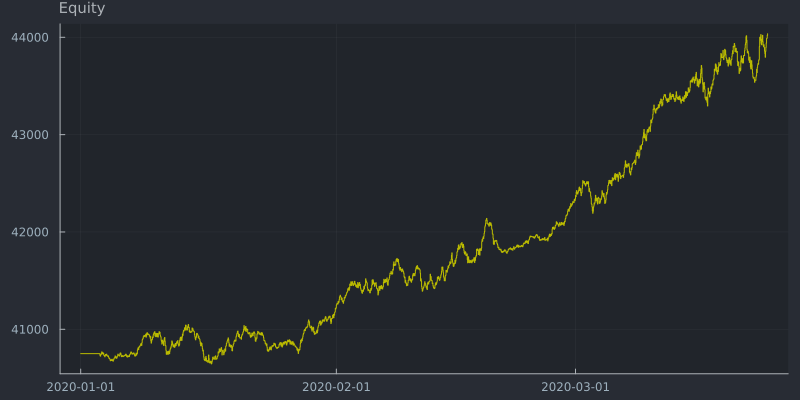

In [2]:
using Plots

theme(:juno)

# plot equity curve
Fastback.plot_equity(equity_data; size=(800, 400))

### Plot account equity drawdown curve

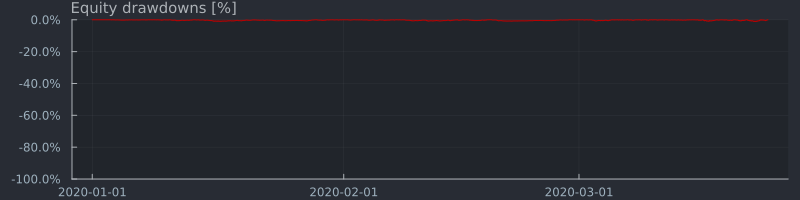

In [3]:
# plot drawdown curve
Fastback.plot_drawdown(drawdown_data; size=(800, 200))